In [2]:
import pandas as pd
import numpy as np
import re
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
import ast
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

### Price Trend

In [73]:
calendar = pd.read_csv("calendar.csv")
calendar[:3]

listing_id        date available    price adjusted_price  minimum_nights  \
0      353292  2021-12-04         f   $90.00         $90.00              30   
1       80394  2021-12-04         t  $135.00        $135.00              30   
2       80394  2021-12-05         t  $135.00        $135.00              30   

   maximum_nights  
0             180  
1              90  
2              90

In [41]:
# check NAs 
calendar.isna().any()

listing_id        False
date              False
available         False
price             False
adjusted_price    False
minimum_nights    False
maximum_nights    False
dtype: bool

In [74]:
calendar['adjusted_price'] = calendar['adjusted_price'].apply(lambda x: float(re.sub("[^\d\.]", "", x)))

In [75]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

chron_prices = calendar.groupby(['date'])['adjusted_price'].agg([np.min, percentile(25), np.median, percentile(75), percentile(90)])

In [76]:
chron_prices.reset_index(inplace=True)

In [77]:
chron_prices_m = chron_prices.melt('date', var_name='metric', value_name='price')
chron_prices_m

date         metric  price
0     2021-12-04           amin   10.0
1     2021-12-05           amin   10.0
2     2021-12-06           amin   10.0
3     2021-12-07           amin   10.0
4     2021-12-08           amin   10.0
...          ...            ...    ...
1820  2022-11-29  percentile_90  413.0
1821  2022-11-30  percentile_90  410.0
1822  2022-12-01  percentile_90  410.0
1823  2022-12-02  percentile_90  431.0
1824  2022-12-03  percentile_90  435.0

[1825 rows x 3 columns]

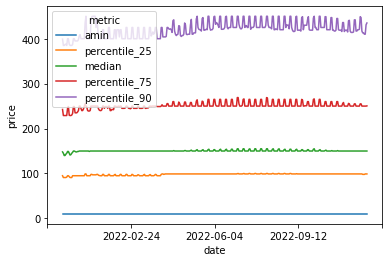

In [79]:
plot_ = sns.lineplot(x='date', y='price', hue='metric', data=chron_prices_m)
plot_.xaxis.set_major_locator(ticker.LinearLocator(5))

C:\Users\92350\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='adjusted_price', ylabel='Density'>

C:\Users\92350\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='adjusted_price', ylabel='Density'>

Text(0.5, 1.0, 'Price Distribution')

Text(0.5, 1.0, 'Price Distribution (<= 95% listings)')

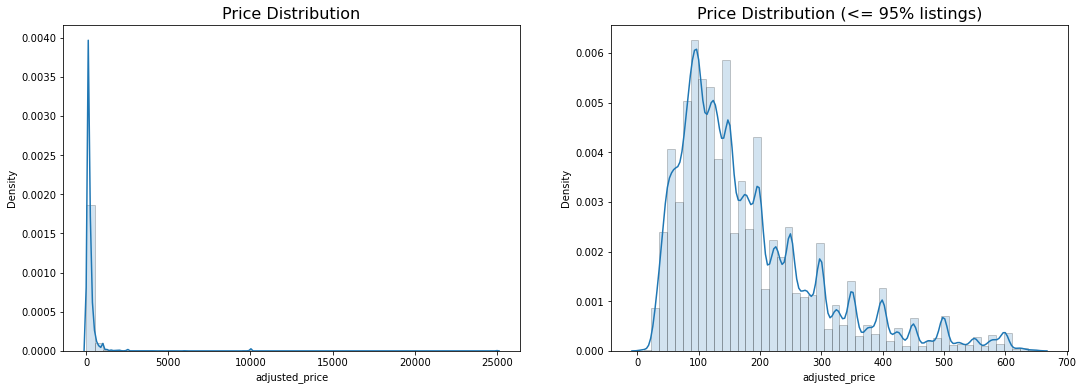

In [85]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(calendar['adjusted_price'] , ax = ax[0], hist_kws=hist_kws)
# price <= 90 quantile's listings
calendar_tmp = calendar[calendar['adjusted_price'] < calendar['adjusted_price'].quantile(.95)]
sns.distplot(calendar_tmp['adjusted_price'] , ax = ax[1], hist_kws=hist_kws)
ax[0].set_title('Price Distribution', fontsize=16)
ax[1].set_title('Price Distribution (<= 95% listings)', fontsize=16)

In [87]:
calendar['adjusted_price'].value_counts(ascending=False).nlargest(10)

150.0    67123
100.0    47398
90.0     42615
250.0    42286
120.0    37782
125.0    35229
95.0     35066
130.0    33478
200.0    33053
110.0    32510
Name: adjusted_price, dtype: int64

### What makes a good listing?

In [261]:
listings = pd.read_csv("listings_1.csv")

In [262]:
# drop unuseful cols
listings.drop(['id','listing_url','scrape_id','last_scraped','name','description', 'neighborhood_overview','picture_url', 'host_id',\
               'host_url','host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'neighbourhood_group_cleansed', \
              'latitude', 'longitude', 'bathrooms',\
              'calendar_updated','calendar_last_scraped'],
             axis = 1, inplace = True)

In [263]:
# process date columns
listings[['host_since','first_review','last_review']] = listings[['host_since','first_review','last_review']].apply(pd.to_datetime, format="%Y-%m-%d")
listings[['host_since','first_review','last_review']] = listings[['host_since','first_review','last_review']].apply(lambda x: abs((x - datetime(2021, 12, 4)).dt.days))

In [264]:
# process numeric data
listings['price'] = listings['price'].apply(lambda x: float(re.sub("[^\d\.]", "", str(x))))

In [265]:
# process numeric data
listings['host_response_rate'] = listings['host_response_rate'].apply(lambda x: float(str(x).split('%')[0]) if x else 0)
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].apply(lambda x: float(str(x).split('%')[0]) if x else 0)

In [266]:
listings[:3]

host_since                                host_location  \
0      4874.0     San Francisco, California, United States   
1      4660.0  San Diego County, California, United States   
2      4553.0     San Francisco, California, United States   

   host_response_time  host_response_rate  host_acceptance_rate  \
0  within a few hours               100.0                  92.0   
1        within a day               100.0                  68.0   
2      within an hour               100.0                 100.0   

  host_is_superhost host_neighbourhood  host_listings_count  \
0                 t    Duboce Triangle                  1.0   
1                 f     Bernal Heights                  2.0   
2                 f        Cole Valley                 10.0   

   host_total_listings_count  \
0                        1.0   
1                        2.0   
2                       10.0   

                                  host_verifications host_has_profile_pic  \
0   ['email', 'phone', 'facebook', 'reviews', 'kba']                    t   
1  ['email', 'phone', 'reviews', 'kba', 'work_ema...                    t   
2  ['email', 'phone', 'reviews', 'jumio', 'govern...                    t   

  host_identity_verified                             neighbourhood  \
0                      t  San Francisco, California, United States   
1                      t  San Francisco, California, United States   
2                      t  San Francisco, California, United States   

  neighbourhood_cleansed                property_type        room_type  \
0       Western Addition    Entire serviced apartment  Entire home/apt   
1         Bernal Heights           Entire rental unit  Entire home/apt   
2         Haight Ashbury  Private room in rental unit     Private room   

   accommodates  bathrooms_text  bedrooms  beds  \
0             3          1 bath       1.0   2.0   
1             5          1 bath       2.0   3.0   
2             2  4 shared baths       1.0   1.0   

                                           amenities  price  minimum_nights  \
0  ["Essentials", "Microwave", "Dryer", "Cable TV...  161.0               2   
1  ["Shampoo", "Hangers", "Essentials", "Kitchen"...  235.0              30   
2  ["Lock on bedroom door", "Hangers", "Kitchen",...   56.0              32   

   maximum_nights  minimum_minimum_nights  maximum_minimum_nights  \
0              30                     2.0                     2.0   
1              60                    30.0                    30.0   
2              60                    32.0                    32.0   

   minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  \
0                  1125.0                  1125.0                     2.0   
1                    60.0                    60.0                    30.0   
2                    60.0                    60.0                    32.0   

   maximum_nights_avg_ntm has_availability  availability_30  availability_60  \
0                  1125.0                t                0                5   
1                    60.0                t               30               60   
2                    60.0                t               30               60   

   availability_90  availability_365  number_of_reviews  \
0               16               126                314   
1               90               365                111   
2               90               365                 19   

   number_of_reviews_ltm  number_of_reviews_l30d  first_review  last_review  \
0                     43                       2        2617.0         15.0   
1                      0                       0        4393.0       2290.0   
2                      0                       0        3386.0        638.0   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                  4.87                    4.94                       4.95   
1                  4.88                    4.85                       4.87   

In [267]:
# fill na
listings = listings.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna('.'))

In [224]:
### ideally, if data set is large engough
host_veri = []
amen = []
for ind, row in listings.iterrows():
    h = row['host_verifications']
    h = ast.literal_eval(h)
    if not h is None:
        for elem in h:
            if elem not in host_veri:
                host_veri.append(elem)
    a = row['amenities']
    a = ast.literal_eval(a)
    if not a is None:        
        for elem in a:
            if elem not in amen:
                amen.append(elem)
len(amen)

1271

In [268]:
# treat list length as feature
def list_len(stri):
    if stri != "" and stri != 'None':
        return len(ast.literal_eval(stri))
    else:
        return 0

listings['n_hostverify'] = listings.apply(lambda x: list_len(x['host_verifications']), axis =1 )
listings['n_amenities'] = listings.apply(lambda x: list_len(x['amenities']), axis =1 )

In [269]:
listings.drop(['host_verifications', 'amenities'], axis = 1, inplace = True)

In [270]:
listings['overall_rating'] = (listings['review_scores_rating'] + listings['review_scores_accuracy']+ listings['review_scores_cleanliness'] \
+ listings['review_scores_checkin'] + listings['review_scores_communication'] + listings['review_scores_location'] \
+ listings['review_scores_value'])/7

In [271]:
listings.drop(['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',\
              'review_scores_communication', 'review_scores_location', 'review_scores_value'], axis = 1, inplace = True)

In [248]:
## listings['target'] = listings['overall_rating'] * listings['reviews_per_month']
## listings.drop(['overall_rating', 'reviews_per_month'], axis = 1, inplace = True)

In [272]:
listings[:3]

host_since                                host_location  \
0      4874.0     San Francisco, California, United States   
1      4660.0  San Diego County, California, United States   
2      4553.0     San Francisco, California, United States   

   host_response_time  host_response_rate  host_acceptance_rate  \
0  within a few hours               100.0                  92.0   
1        within a day               100.0                  68.0   
2      within an hour               100.0                 100.0   

  host_is_superhost host_neighbourhood  host_listings_count  \
0                 t    Duboce Triangle                  1.0   
1                 f     Bernal Heights                  2.0   
2                 f        Cole Valley                 10.0   

   host_total_listings_count host_has_profile_pic host_identity_verified  \
0                        1.0                    t                      t   
1                        2.0                    t                      t   
2                       10.0                    t                      t   

                              neighbourhood neighbourhood_cleansed  \
0  San Francisco, California, United States       Western Addition   
1  San Francisco, California, United States         Bernal Heights   
2  San Francisco, California, United States         Haight Ashbury   

                 property_type        room_type  accommodates  bathrooms_text  \
0    Entire serviced apartment  Entire home/apt             3          1 bath   
1           Entire rental unit  Entire home/apt             5          1 bath   
2  Private room in rental unit     Private room             2  4 shared baths   

   bedrooms  beds  price  minimum_nights  maximum_nights  \
0       1.0   2.0  161.0               2              30   
1       2.0   3.0  235.0              30              60   
2       1.0   1.0   56.0              32              60   

   minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  \
0                     2.0                     2.0                  1125.0   
1                    30.0                    30.0                    60.0   
2                    32.0                    32.0                    60.0   

   maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm  \
0                  1125.0                     2.0                  1125.0   
1                    60.0                    30.0                    60.0   
2                    60.0                    32.0                    60.0   

  has_availability  availability_30  availability_60  availability_90  \
0                t                0                5               16   
1                t               30               60               90   
2                t               30               60               90   

   availability_365  number_of_reviews  number_of_reviews_ltm  \
0               126                314                     43   
1               365                111                      0   
2               365                 19                      0   

   number_of_reviews_l30d  first_review  last_review  \
0                       2        2617.0         15.0   
1                       0        4393.0       2290.0   
2                       0        3386.0        638.0   

                     license instant_bookable  calculated_host_listings_count  \
0  City Registration Pending                f                               1   
1                          .                f                               1   
2                          .                f                               9   

   calculated_host_listings_count_entire_homes  \
0                                            1   
1                                            1   
2                                            0   

   calculated_host_listings_count_private_rooms  \
0                                             0   
1                                             0   
2   

In [300]:
num_fea = []
for col in listings:
    if listings[col].dtype.kind in 'biufc':
        num_fea.append(col)

listings_s = listings.copy()
for i in num_fea:
    
    # fit on training data column
    scale = StandardScaler().fit(listings_s[[i]])
    
    # transform the data column
    listings_s[i] = scale.transform(listings_s[[i]])

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='overall_rating', ylabel='Density'>

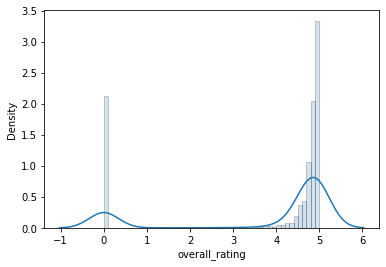

In [293]:
sns.distplot(listings['overall_rating'], hist_kws=hist_kws)

In [273]:
cat_set = set({"host_location","host_response_time","host_is_superhost","host_neighbourhood","host_has_profile_pic",\
               'host_identity_verified','neighbourhood','neighbourhood_cleansed','property_type','room_type','bathrooms_text',\
              'has_availability','license','instant_bookable'})

In [302]:
target = listings_s['overall_rating']
data = listings_s.copy()
data.drop(['overall_rating'], axis = 1, inplace = True)
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 42)
cat_index = []
for idx, cn in enumerate(x_train.columns):
    if cn in cat_set:
        cat_index.append(idx)

train_pool = Pool(x_train, 
              y_train, 
              cat_features=cat_index,
              feature_names=list(x_train.columns))
test_pool = Pool(x_test,
             y_test,
             cat_features=cat_index,
             feature_names=list(x_test.columns))

In [288]:
model = CatBoostRegressor(iterations=100, 
                          depth = 12,
                          border_count=254,
                          learning_rate=.1, 
                          loss_function='RMSE',
                          random_strength=1,
                          one_hot_max_size=8,
                          l2_leaf_reg=3,
                          grow_policy='SymmetricTree',)

In [ ]:
model.fit(train_pool, early_stopping_rounds=5, eval_set=test_pool, use_best_model=True)

In [304]:
pred = model.predict(x_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
rmse
r2

0.19152426612933804

0.9627142432680033

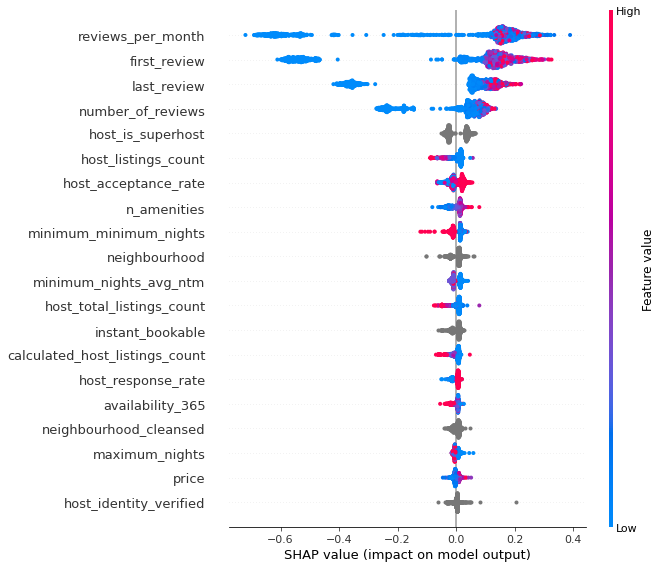

In [305]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, feature_names = list(x_train.columns))

<BarContainer object of 47 artists>

([<matplotlib.axis.YTick at 0x20f226003d0>,
 [Text(0, 0, 'license'),
  Text(0, 1, 'number_of_reviews_l30d'),
  Text(0, 2, 'calculated_host_listings_count_shared_rooms'),
  Text(0, 3, 'host_location'),
  Text(0, 4, 'number_of_reviews_ltm'),
  Text(0, 5, 'accommodates'),
  Text(0, 6, 'bedrooms'),
  Text(0, 7, 'host_has_profile_pic'),
  Text(0, 8, 'maximum_minimum_nights'),
  Text(0, 9, 'has_availability'),
  Text(0, 10, 'availability_90'),
  Text(0, 11, 'calculated_host_listings_count_entire_homes'),
  Text(0, 12, 'minimum_nights_avg_ntm'),
  Text(0, 13, 'host_neighbourhood'),
  Text(0, 14, 'room_type'),
  Text(0, 15, 'property_type'),
  Text(0, 16, 'n_hostverify'),
  Text(0, 17, 'calculated_host_listings_count_private_rooms'),
  Text(0, 18, 'host_response_rate'),
  Text(0, 19, 'maximum_nights'),
  Text(0, 20, 'availability_60'),
  Text(0, 21, 'host_response_time'),
  Text(0, 22, 'calculated_host_listings_count'),
  Text(0, 23, 'maximum_nights_avg_ntm'),
  Text(0, 24, 'host_since'),
  Te

Text(0.5, 1.0, 'Feature Importance')

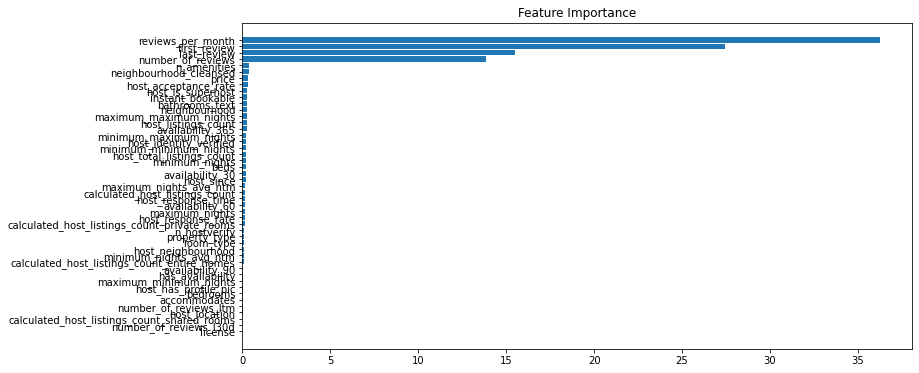

In [306]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [307]:
pool = Pool(x_train, y_train, cat_features=cat_index, feature_names=list(x_train.columns))
model.plot_tree(
    tree_idx=0,
    pool=pool
)

### Does the situation differs for expensive and cheap listings?

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='overall_rating', ylabel='Density'>

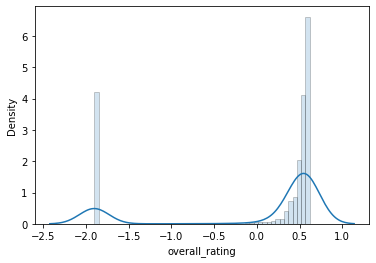

In [319]:
sns.distplot(listings_s['overall_rating'], hist_kws=hist_kws)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0:	learn: 0.9620516	test: 0.9238013	best: 0.9238013 (0)	total: 67.8ms	remaining: 6.71s
1:	learn: 0.8728354	test: 0.8389619	best: 0.8389619 (1)	total: 79.8ms	remaining: 3.91s
2:	learn: 0.8092169	test: 0.7826351	best: 0.7826351 (2)	total: 181ms	remaining: 5.85s
3:	learn: 0.7423175	test: 0.7204250	best: 0.7204250 (3)	total: 295ms	remaining: 7.07s
4:	learn: 0.6816745	test: 0.6629566	best: 0.6629566 (4)	total: 365ms	remaining: 6.93s
5:	learn: 0.6248032	test: 0.6084394	best: 0.6084394 (5)	total: 389ms	remaining: 6.09s
6:	learn: 0.5755551	test: 0.5622797	best: 0.5622797 (6)	total: 503ms	remaining: 6.68s
7:	learn: 0.5323446	test: 0.5229438	best: 0.5229438 (7)	total: 557ms	remaining: 6.4s
8:	learn: 0.4979117	test: 0.4942475	best: 0.4942475 (8)	total: 679ms	remaining: 6.86s
9:	learn: 0.4619383	test: 0.4615725	best: 0.4615725 (9)	total: 757ms	remaining: 6.81s
10:	learn: 0.4295030	test: 0.4330171	best: 0.4330171 (10)	total: 876ms	remaining: 7.09s
11:	learn: 0.3959531	test: 0.4023551	best: 0.402355

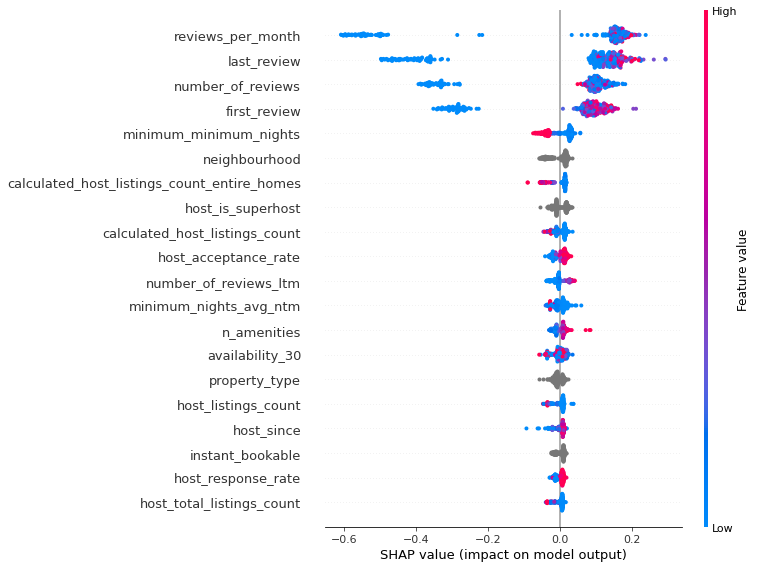

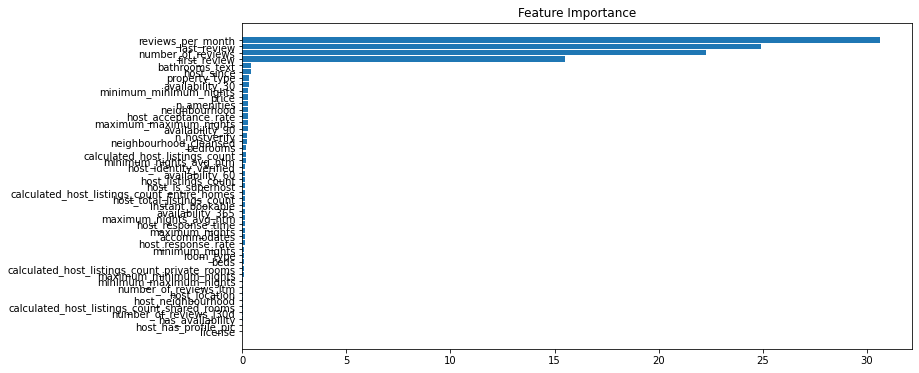

In [321]:
high_l = listings_s[listings_s['price'] >= 0]
low_l = listings_s[listings_s['price'] < 0]

def model_res(data):
    target = data['overall_rating']
    data.drop(['overall_rating'], axis = 1, inplace = True)
    x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 42)
    cat_index = []
    for idx, cn in enumerate(x_train.columns):
        if cn in cat_set:
            cat_index.append(idx)

    train_pool = Pool(x_train, 
                  y_train, 
                  cat_features=cat_index,
                  feature_names=list(x_train.columns))
    test_pool = Pool(x_test,
                 y_test,
                 cat_features=cat_index,
                 feature_names=list(x_test.columns))

    model.fit(train_pool, early_stopping_rounds=5, eval_set=test_pool, use_best_model=True, verbose=None)
    pred = model.predict(x_test)
    rmse = (np.sqrt(mean_squared_error(y_test, pred)))
    r2 = r2_score(y_test, pred)
    print('RMSE:', rmse)
    print('r2:', r2)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)
    shap.summary_plot(shap_values, x_test, feature_names = list(x_train.columns))
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(x_test.columns)[sorted_idx])
    plt.title('Feature Importance')

model_res(high_l)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0:	learn: 0.8961112	test: 0.9069748	best: 0.9069748 (0)	total: 37ms	remaining: 3.66s
1:	learn: 0.8190811	test: 0.8313662	best: 0.8313662 (1)	total: 158ms	remaining: 7.75s
2:	learn: 0.7663741	test: 0.7822960	best: 0.7822960 (2)	total: 287ms	remaining: 9.27s
3:	learn: 0.7010631	test: 0.7170657	best: 0.7170657 (3)	total: 415ms	remaining: 9.95s
4:	learn: 0.6385059	test: 0.6531836	best: 0.6531836 (4)	total: 428ms	remaining: 8.14s
5:	learn: 0.5882536	test: 0.6034523	best: 0.6034523 (5)	total: 546ms	remaining: 8.55s
6:	learn: 0.5421166	test: 0.5563996	best: 0.5563996 (6)	total: 677ms	remaining: 9s
7:	learn: 0.4993430	test: 0.5130965	best: 0.5130965 (7)	total: 753ms	remaining: 8.66s
8:	learn: 0.4626904	test: 0.4756815	best: 0.4756815 (8)	total: 883ms	remaining: 8.92s
9:	learn: 0.4278034	test: 0.4402789	best: 0.4402789 (9)	total: 916ms	remaining: 8.24s
10:	learn: 0.3970332	test: 0.4086946	best: 0.4086946 (10)	total: 962ms	remaining: 7.78s
11:	learn: 0.3705148	test: 0.3817772	best: 0.3817772 (11

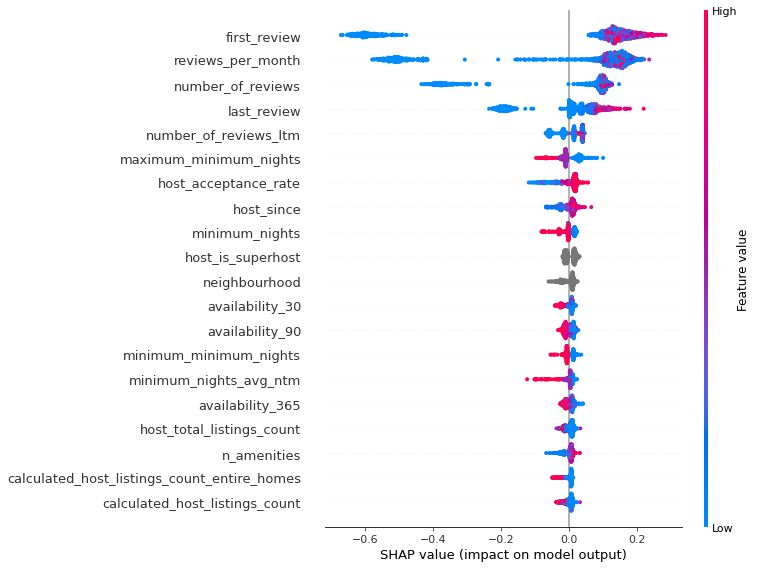

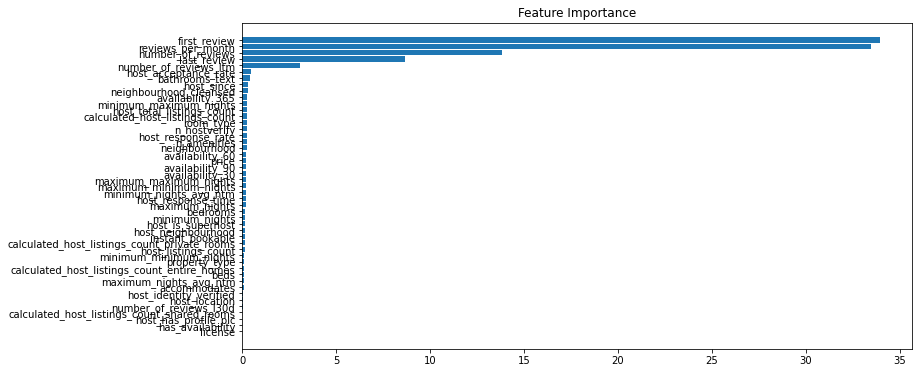

In [322]:
model_res(low_l)

In [324]:
# more reviews for cheaper listings.
high_l['reviews_per_month'].mean()
low_l['reviews_per_month'].mean()

-0.078229189499519

0.026637823932842586

### Keywords Extraction

In [3]:
import transformers, datasets

In [4]:
review = pd.read_csv("reviews_1.csv")

In [7]:
review_958 = review[review['listing_id'] == 958]

In [11]:
from transformers import (
    TokenClassificationPipeline,
    AutoModelForTokenClassification,
    AutoTokenizer,
)
from transformers.pipelines import AggregationStrategy
import numpy as np

# Define keyphrase extraction pipeline
class KeyphraseExtractionPipeline(TokenClassificationPipeline):
    def __init__(self, model, *args, **kwargs):
        super().__init__(
            model=AutoModelForTokenClassification.from_pretrained(model),
            tokenizer=AutoTokenizer.from_pretrained(model),
            *args,
            **kwargs
        )

    def postprocess(self, model_outputs):
        results = super().postprocess(
            model_outputs=model_outputs,
            aggregation_strategy=AggregationStrategy.SIMPLE,
        )
        return np.unique([result.get("word").strip() for result in results])


In [12]:
# Load pipeline
model_name = "ml6team/keyphrase-extraction-kbir-inspec"
extractor = KeyphraseExtractionPipeline(model=model_name)

Downloading:   0%|          | 0.00/855 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.01M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [16]:
s = review_958['comments'][0]
keyphrases = extractor(s)

In [23]:
keywords = []
for ind, row in review_958.iterrows():
    cmt = row['comments']
    tmp_l = extractor(cmt).tolist()
    keywords.extend(tmp_l)

In [26]:
from collections import Counter
c = Counter(keywords)
c.most_common(10)

[('Duboce Park', 18),
 ('San Francisco', 15),
 ('public transportation', 13),
 ('Airbnb', 10),
 ('public transport', 10),
 ('Muni', 9),
 ('public transit', 6),
 ('Duboce park', 5),
 ('restaurants', 5),
 ('Holly', 5)]